<h1 align=center><font size = 10> k-Means </font></h1>

In this notebook, we try to practice one of the most popular algorithms in Clustering that we learned in this course: k-Means algorithm. 

We load a dataset using Pandas library and apply k-Means to explore information from data.
Lets first load required libraries:

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot') # Look Pretty

def showandtell(title=None):
  plt.show()

A convenience function for you to use:

In [2]:
def clusterInfo(model):
    print("Cluster Analysis Inertia: ", model.inertia_)
    print('------------------------------------------')
    
    for i in range(len(model.cluster_centers_)):
        print("\n  Cluster ", i)
        print("    Centroid ", model.cluster_centers_[i])
        print("    #Samples ", (model.labels_==i).sum()) # NumPy Power

In [3]:
# Find the cluster with the least # attached nodes
def clusterWithFewestSamples(model):
    # Ensure there's at least on cluster...
    minSamples = len(model.labels_)
    minCluster = 0
    
    for i in range(len(model.cluster_centers_)):
        if minSamples > (model.labels_==i).sum():
            minCluster = i
            minSamples = (model.labels_==i).sum()

    print("\n  Cluster With Fewest Samples: ", minCluster)
    return (model.labels_== minCluster)

# Mandatory part (85%  of the total score)

### About dataset

A [call detail record](https://en.wikipedia.org/wiki/Call_detail_record) 

*   List item
*   List item

(CDR) is a data record produced by a telephone exchange or other telecommunications equipment that documents the details of a telephone call or other telecommunications transaction (e.g., text message) that passes through that facility or device.

The questions you'll be exploring in this lab assignment using K-Means are: exactly how useful is telephone metadata? It must have some use, otherwise, the government wouldn't have invested however many millions they did into it secretly collecting it from phone carriers. Also what kind of intelligence can you extract from CDR metadata besides its face value?

The record contains various attributes of the call, such as time, duration, completion status, source number, and destination number. It is the automated equivalent of the paper toll tickets that were written and timed by operators for long-distance calls in a manual telephone exchange.

The dataset we've curated for you contains call records of 10 people, tracked over the course of 3 years. Your job in this assignment is to find out where each of these people likely live and where they work at!


**1. Start by loading up the dataset and taking a peek at its head. You have to convert date-strings to real date-time objects using `pd.to_datetime`, and the times using `pd.to_timedelta`:**

In [4]:
data = pd.read_csv('CDRASM3.csv')
data.head()
data['CallDate'] = pd.to_datetime(data['CallDate'])
data['CallTime'] = pd.to_timedelta(data['CallTime'])
data.dtypes

In                     int64
Out                    int64
Direction             object
CallDate      datetime64[ns]
CallTime     timedelta64[ns]
DOW                   object
Duration              object
TowerID               object
TowerLat             float64
TowerLon             float64
dtype: object

**2. Create a distinct list of `In` phone numbers (people) and store the values in a regular python list.**

Make sure the numbers appear in your list in the same order they appear in your dataframe; but only keep a single copy of each number. [This link](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html) might also be helpful.

In [5]:
list_In = data['In'].unique().tolist()
list_In

[4638472273,
 1559410755,
 4931532174,
 2419930464,
 1884182865,
 3688089071,
 4555003213,
 2068627935,
 2894365987,
 8549533077]

In [6]:
data['In'].value_counts()

2894365987    12053
1559410755    11633
8549533077     7741
2068627935     5835
4638472273     3648
4931532174     2896
1884182865     2865
2419930464     2497
4555003213     2410
3688089071     1610
Name: In, dtype: int64

**3. Create a slice named `user1` that filters to _only_ include dataset records where the `In` feature (user's phone number) is equal to the first number on your unique list above, i.e., the very first number in the dataset:**

In [7]:
user1 = data[data['In'] == list_In[0]]
user1

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,0 days 07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,0 days 21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,0 days 14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,0 days 16:02:09.001913,Sat,0:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,0 days 15:28:35.028554,Sat,0:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389
...,...,...,...,...,...,...,...,...,...,...
53140,4638472273,2666307251,Missed,2013-02-26,0 days 11:26:01.888502,Tue,0:03:08.177065,0296279d-18c3-4709-853e-3e20496ce444,32.899944,-96.910389
53141,4638472273,2145623768,Missed,2013-02-26,0 days 17:32:18.776276,Tue,0:02:30.823459,78512965-e30b-4734-ae92-47b910fe3d7f,32.899944,-96.910389
53142,4638472273,4551601645,Incoming,2013-02-26,0 days 19:12:44.730636,Tue,0:03:42.954201,8fb02570-fb3f-4381-be74-3e1accf87ec5,32.750556,-96.694722
53143,4638472273,7721472178,Incoming,2013-02-26,0 days 07:50:41.435642,Tue,0:04:04.460385,e78826ad-45b0-45d4-90ec-4776d73f1d8e,32.864167,-96.836944


**4. Let's go ahead and plot all the call locations for user 1 in all time:**


Text(0, 0.5, 'TowerLat')

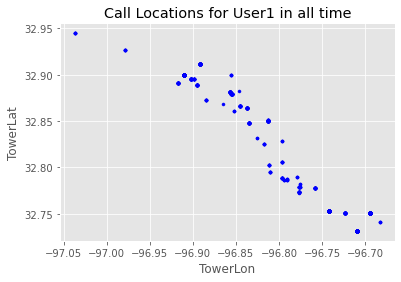

In [8]:
plt.scatter(user1['TowerLon'], user1['TowerLat'], marker = '.', c = 'blue')
plt.title('Call Locations for User1 in all time')
plt.xlabel('TowerLon')
plt.ylabel('TowerLat')

INFO: The locations map above should be too "busy" to really wrap your head around. This is where domain expertise comes into play. Your intuition can direct you by knowing people are likely to behave differently on weekends vs on weekdays:

#### On Weekends
1. People probably don't go into work
1. They probably sleep in late on Saturday
1. They probably run a bunch of random errands, since they couldn't during the week
1. They should be home, at least during the very late hours, e.g. 1-4 AM

#### On Weekdays
1. People probably are at work during normal working hours
1. They probably are at home in the early morning and during the late night
1. They probably spend time commuting between work and home everyday

**5. Add more filters to the `user1` slice you created. Add bitwise logic so that you only examine records that _came in_ on weekends (sat/sun):**

In [9]:
user1_weekends = user1[(user1['DOW'] == 'Sat') | (user1['DOW'] == 'Sun')]
user1_weekends

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
0,4638472273,2666307251,Incoming,2010-12-25,0 days 07:16:24.736813,Sat,0:02:41.741499,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
1,4638472273,1755442610,Incoming,2010-12-25,0 days 21:18:30.053710,Sat,0:02:47.108750,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
2,4638472273,5481755331,Incoming,2010-12-25,0 days 14:52:42.878016,Sat,0:04:35.356341,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
3,4638472273,1755442610,Incoming,2010-12-25,0 days 16:02:09.001913,Sat,0:02:23.498499,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
4,4638472273,2145623768,Incoming,2010-12-25,0 days 15:28:35.028554,Sat,0:03:54.692497,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389
...,...,...,...,...,...,...,...,...,...,...
52964,4638472273,6022767590,Incoming,2013-02-23,0 days 16:12:12.701600,Sat,0:02:21.278138,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
52965,4638472273,5621270003,Incoming,2013-02-23,0 days 09:11:21.606945,Sat,0:03:19.757526,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
53022,4638472273,7756914135,Incoming,2013-02-24,0 days 16:49:42.830258,Sun,0:02:19.285474,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
53023,4638472273,7721472178,Incoming,2013-02-24,0 days 10:32:55.146952,Sun,0:00:04.908620,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389


**6. Further filter `user1` down for calls that came in either before 6am OR after 10pm (22:00:00).**

Even if you didn't convert your times from string objects to time deltas, you can still use `<` and `>` to compare the string times as long as you code them as [military time strings](https://en.wikipedia.org/wiki/24-hour_clock), eg: "06:00:00", "22:00:00": 

You may also want to review the Data Manipulation section for this. Once you have your filtered slice, print out its length:

In [10]:
user1_weekends_6am_10pm = user1_weekends[(user1_weekends['CallTime'] < '06:00:00') | (user1_weekends['CallTime'] == '22:00:00')]
user1_weekends_6am_10pm

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
7468,4638472273,7756914135,Incoming,2011-04-17,0 days 05:15:40.205917,Sun,0:02:09.984993,cd9f3b1a-2eb8-4cdb-86d1-5d4c2740b1dc,32.731722,-96.709500
9753,4638472273,7922223441,Incoming,2011-05-21,0 days 05:08:20.121145,Sat,0:01:30.059591,0db53dd3-eb9c-4344-abc5-c2d74ebc3eec,32.731611,-96.709417
17515,4638472273,2666307251,Incoming,2011-09-11,0 days 05:44:15.432523,Sun,0:01:39.500414,bcec0121-164d-406c-8c04-d12870893992,32.731611,-96.709417
21638,4638472273,6150928001,Incoming,2011-11-13,0 days 05:10:41.954161,Sun,0:00:44.369613,f3f289f5-7d29-4d3f-9b9a-a0ceaca10a1d,32.750556,-96.694722
31975,4638472273,1755442610,Incoming,2012-04-14,0 days 05:42:32.004437,Sat,0:07:02.657988,d760c426-4d58-4f9c-9950-b68a3a54612c,32.731611,-96.709417
32606,4638472273,7922223441,Incoming,2012-04-22,0 days 05:02:55.678110,Sun,0:03:50.596153,8ba7e0d7-eb6e-4828-9c70-c469954a627d,32.731611,-96.709417
34427,4638472273,5621270003,Incoming,2012-05-19,0 days 05:42:45.405430,Sat,0:03:33.104834,2567c73b-3711-4a31-8683-9d12d56857d8,32.731611,-96.709417
38110,4638472273,2145623768,Incoming,2012-07-15,0 days 05:59:38.556670,Sun,0:04:29.583137,1bfc786a-d4c2-464c-bc45-b9aad0c81216,32.731722,-96.709500
40275,4638472273,7756914135,Missed,2012-08-19,0 days 05:33:32.103650,Sun,0:01:35.932559,aeaf8b43-8034-44fe-833d-31854a75acbf,32.731722,-96.709500
42224,4638472273,7922223441,Incoming,2012-09-15,0 days 05:14:40.655349,Sat,0:04:07.561627,cd9f3b1a-2eb8-4cdb-86d1-5d4c2740b1dc,32.731722,-96.709500


**7. Visualize the dataframe with a scatter plot as a sanity check.**

Since you're [familiar with maps](https://en.wikipedia.org/wiki/Geographic_coordinate_system#Geographic_latitude_and_longitude), you know well that your X-Coordinate should be Longitude, and your Y coordinate should be the tower Latitude. Check the dataset headers for proper column feature names.
 
At this point, you don't yet know exactly where the user is located just based on the cell phone tower position data; but considering the below are for Calls that arrived in the twilight hours of weekends, it's likely that wherever they are bunched up is probably near where the caller's residence:

Text(0.5, 1.0, 'Weekends Call (<6am and >10pm) for User1')

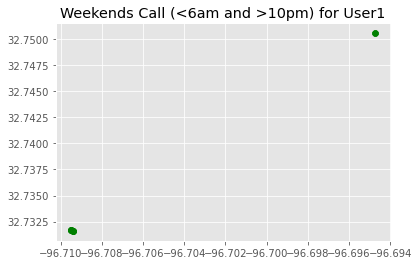

In [11]:
plt.scatter(user1_weekends_6am_10pm['TowerLon'], user1_weekends_6am_10pm['TowerLat'], c = 'green')
plt.title('Weekends Call (<6am and >10pm) for User1')

**8. Run K-Means on that dataframe with `K=2` then print out the Cluster Info using clusterInfo function**, with the goal being that one of the centroids will sweep up the annoying outliers; and the other will zero in on the user's approximate home location. Or rather the location of the cell tower closest to their home.....

Be sure to only feed in Lat and Lon coordinates to the KMeans algorithm since none of the other data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale, no feature scaling is required.

In [12]:
from sklearn.cluster import KMeans
k_means_model = KMeans(init = 'k-means++', n_clusters = 2, n_init = 4) 
k_means_model.fit(user1_weekends_6am_10pm[['TowerLon','TowerLat']])
print(k_means_model.cluster_centers_)
print(k_means_model.labels_)

clusterInfo(k_means_model)

[[-96.70946227  32.73167155]
 [-96.694722    32.750556  ]]
[0 0 0 1 0 0 0 0 0 0 0 1 0]
Cluster Analysis Inertia:  5.239090909064356e-08
------------------------------------------

  Cluster  0
    Centroid  [-96.70946227  32.73167155]
    #Samples  11

  Cluster  1
    Centroid  [-96.694722  32.750556]
    #Samples  2


**9. Add centroid locations onto your scatter plot. Use a distinguishable marker and color.**

Hint: Make sure you graph the CORRECT coordinates. This is part of your domain expertise.

Text(0.5, 1.0, 'Weekends Call (<6am and >10pm) for User1')

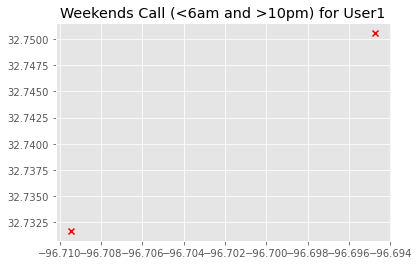

In [13]:
x = k_means_model.cluster_centers_[0:,0].tolist()
y = k_means_model.cluster_centers_[0:,1].tolist()
plt.scatter(x,y,marker = 'x', c = 'red')
plt.title('Weekends Call (<6am and >10pm) for User1')

**10. Now that you have a system in place, repeat the above steps (4, 8, and 9) for all 10 individuals in the dataset**. 

You might want to use a for-loop unless you enjoy copying and pasting:

<ipython-input-14-5419f367ac2f>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  k_means_model.fit(user_weekends_6am_10pm[['TowerLon','TowerLat']])
<ipython-input-14-5419f367ac2f>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  k_means_model.fit(user_weekends_6am_10pm[['TowerLon','TowerLat']])
<ipython-input-14-5419f367ac2f>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  k_means_model.fit(user_weekends_6am_10pm[['TowerLon','TowerLat']])


Cluster Info of User 1
Cluster Analysis Inertia:  5.239090909064356e-08
------------------------------------------

  Cluster  0
    Centroid  [-96.70946227  32.73167155]
    #Samples  11

  Cluster  1
    Centroid  [-96.694722  32.750556]
    #Samples  2


Cluster Info of User 2
Cluster Analysis Inertia:  0.0
------------------------------------------

  Cluster  0
    Centroid  [-96.923556  32.870972]
    #Samples  35

  Cluster  1
    Centroid  [-96.923528  32.870944]
    #Samples  9


Cluster Info of User 3
Cluster Analysis Inertia:  0.0
------------------------------------------

  Cluster  0
    Centroid  [-96.866028  32.865806]
    #Samples  6

  Cluster  1
    Centroid  [-96.864472  32.865806]
    #Samples  8


Cluster Info of User 4
Cluster Analysis Inertia:  0.00010617442830775874
------------------------------------------

  Cluster  0
    Centroid  [-96.835175    32.84636523]
    #Samples  13

  Cluster  1
    Centroid  [-96.852389  32.861222]
    #Samples  1


Cluster Info

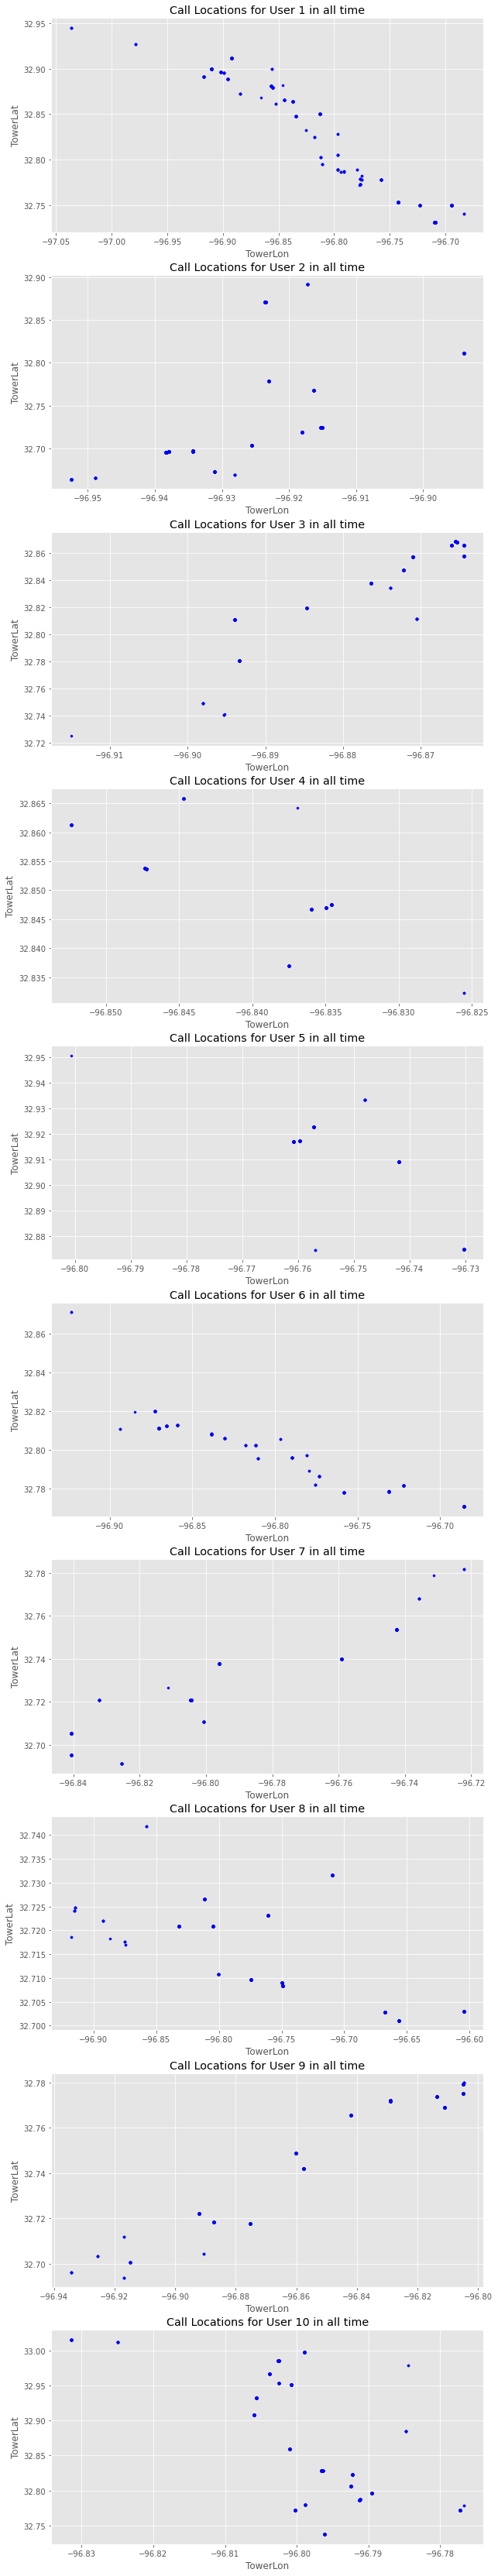

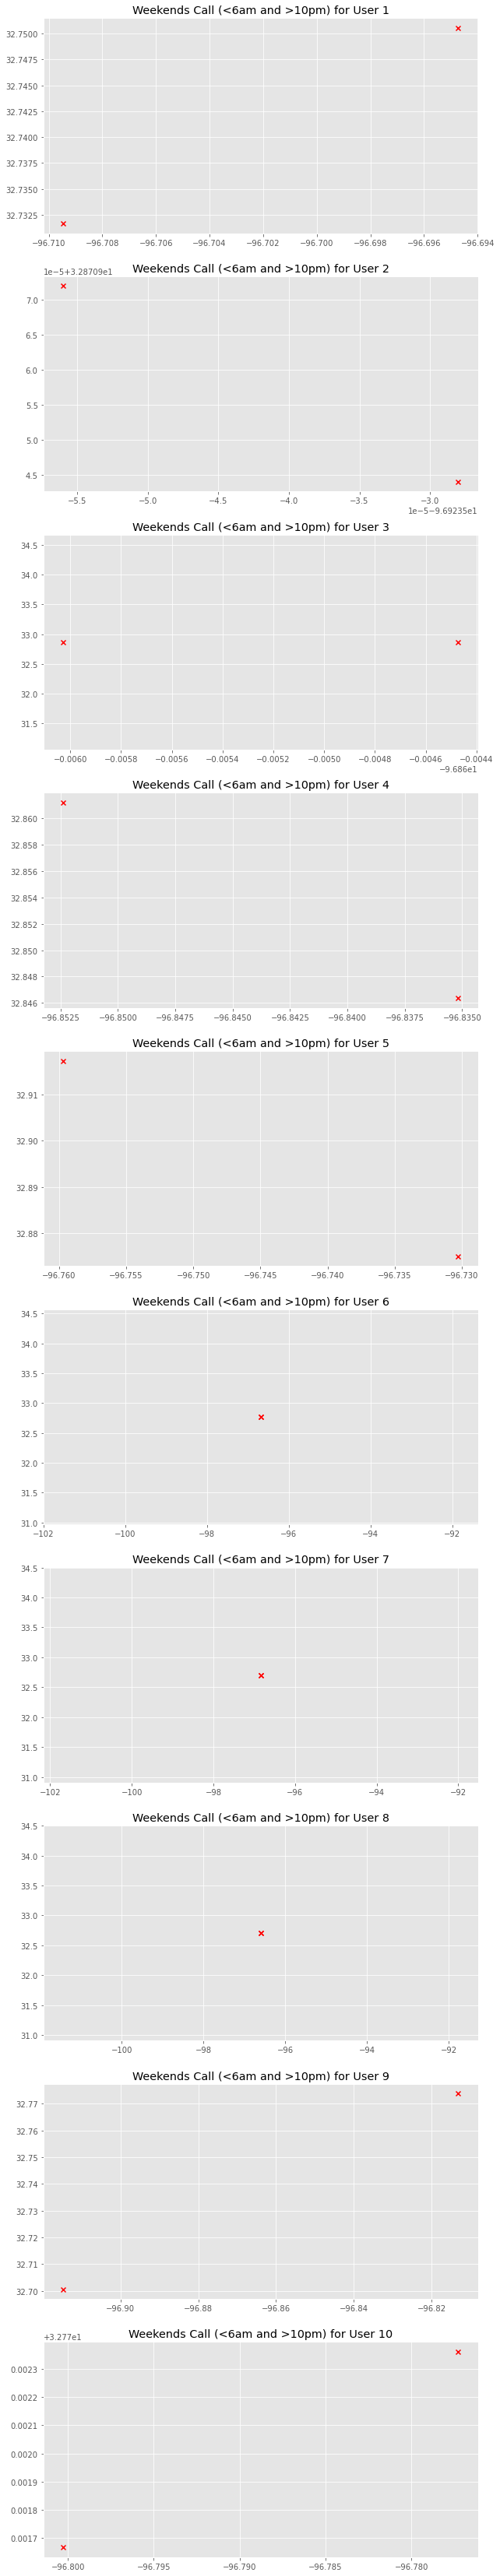

In [14]:
models = []
#TO DO:
fig1, ax1 = plt.subplots(len(list_In), figsize = (10,60))   
for i in range(0,len(list_In)):
    user = data[data['In'] == list_In[i]]
    user_weekends = user[(user['DOW'] == 'Sat') | (user['DOW'] == 'Sun')]
    user_weekends_6am_10pm = user_weekends[(user_weekends['CallTime'] < '06:00:00') | (user_weekends['CallTime'] == '22:00:00')]
    
    ax1[i].scatter(user['TowerLon'], user['TowerLat'], marker = '.', c = 'blue')
    ax1[i].set_title('Call Locations for User ' + str(i+1) + ' in all time')
    ax1[i].set_xlabel('TowerLon')
    ax1[i].set_ylabel('TowerLat')
    
    k_means_model = KMeans(init = 'k-means++', n_clusters = 2, n_init = 2) 
    k_means_model.fit(user_weekends_6am_10pm[['TowerLon','TowerLat']])
    models.append(k_means_model)

    
fig, ax = plt.subplots(len(models), figsize = (10,60))
for i in range(len(models)):
    print('Cluster Info of User ' + str(i+1))
    clusterInfo(models[i])
    print('\n')
    x = models[i].cluster_centers_[0:,0].tolist()
    y = models[i].cluster_centers_[0:,1].tolist()
    ax[i].scatter(x,y, marker = 'x', c = 'red')
    ax[i].set_title('Weekends Call (<6am and >10pm) for User ' + str(i+1))

**11. Alter your slice from user1, so that it includes only Weekday (Mon-Fri) values and before 5pm:**

The idea is that the call was placed before 5pm. From Midnight-730a, the user is probably sleeping and won't call/wake up to take a call. There should be a brief time in the morning during their commute to work, then they'll spend the entire day at work. So the assumption is that most of the time is spent either at work or at the second, at home:
        

In [15]:
user1_weekday = user1[(user1['DOW'] != 'Sat') & (user1['DOW'] != 'Sun')]
user1_weekday_daytime = user1_weekday[user1_weekday['CallTime'] < '17:00:00']

user1_weekday_daytime

,In,Out,Direction,CallDate,CallTime,DOW,Duration,TowerID,TowerLat,TowerLon
197,4638472273,5481755331,Incoming,2010-12-28,0 days 16:20:11.532130,Tue,0:03:56.069765,95d7920d-c3cd-4d20-a568-9a55800dc807,32.899944,-96.910389
200,4638472273,8180005891,Incoming,2010-12-28,0 days 15:27:51.105337,Tue,0:03:30.047757,95c91e8b-6ff1-4893-9df3-b0342636bd25,32.899944,-96.910389
248,4638472273,8180005891,Missed,2010-12-29,0 days 09:13:35.198987,Wed,0:02:10.574446,95c91e8b-6ff1-4893-9df3-b0342636bd25,32.899944,-96.910389
249,4638472273,2145623768,Incoming,2010-12-29,0 days 06:02:11.319738,Wed,0:04:34.436752,9baa92e7-e990-4e9e-8c0a-4c17cb4ecc7c,32.731611,-96.709417
250,4638472273,8068555700,Incoming,2010-12-29,0 days 13:54:14.724722,Wed,0:03:31.297111,fadaa83f-6001-45fd-aa4a-17d6c6b7ec00,32.899944,-96.910389
...,...,...,...,...,...,...,...,...,...,...
53091,4638472273,6150928001,Missed,2013-02-25,0 days 16:55:01.129212,Mon,0:02:48.163010,0296279d-18c3-4709-853e-3e20496ce444,32.899944,-96.910389
53138,4638472273,8068555700,Incoming,2013-02-26,0 days 07:28:38.486982,Tue,0:03:51.307727,cd9f3b1a-2eb8-4cdb-86d1-5d4c2740b1dc,32.731722,-96.709500
53140,4638472273,2666307251,Missed,2013-02-26,0 days 11:26:01.888502,Tue,0:03:08.177065,0296279d-18c3-4709-853e-3e20496ce444,32.899944,-96.910389
53143,4638472273,7721472178,Incoming,2013-02-26,0 days 07:50:41.435642,Tue,0:04:04.460385,e78826ad-45b0-45d4-90ec-4776d73f1d8e,32.864167,-96.836944


In [16]:
user1_weekday_daytime.shape

(1405, 10)

**12. Plot the Cell Towers the above data frame:**


Text(0, 0.5, 'TowerLat')

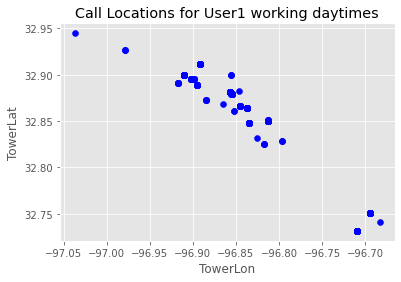

In [17]:
plt.scatter(user1_weekday_daytime['TowerLon'], user1_weekday_daytime['TowerLat'], marker = 'o', c = 'blue')
plt.title('Call Locations for User1 working daytimes')
plt.xlabel('TowerLon')
plt.ylabel('TowerLat')

**13. Complete the doKmeans function:**

In [18]:
#TO DO:
def doKMeans(data, num_clusters = 0):
    # TODO: Be sure to only feed in Lat and Lon coordinates to the KMeans algo, since none of the other
    # data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale,
    # no feature scaling is required. Print out the centroid locations and add them onto your scatter
    # plot. Use a distinguishable marker and color.
    #
    # Hint: Make sure you fit ONLY the coordinates, and in the CORRECT order (lat first). This is part
    # of your domain expertise. Also, *YOU* need to create, initialize (and return) the variable named
    # `model` here, which will be a SKLearn K-Means model for this to work:
    
    # .. your code here ..
    model = KMeans(init = 'k-means++', n_clusters = num_clusters, n_init = 4) 
    model.fit(data[['TowerLon','TowerLat']])
    return model

**14. Let's tun K-Means with `K=3`using doKMeans function for that dataframe (user1 on weekdays in daytime). Then print out the cluster info using clusterInfo function:**

There should only be two areas of concentration. If you notice multiple areas that are "hot" (multiple areas the user spends a lot of time at that are FAR apart from one another).

In [19]:
model_user1 = doKMeans(user1_weekday_daytime,3)
print(model_user1.labels_)
print(model_user1.cluster_centers_)
clusterInfo(model_user1)

[0 0 0 ... 0 2 2]
[[-96.90951639  32.9000009 ]
 [-96.70816184  32.73323174]
 [-96.83818346  32.86348712]]
Cluster Analysis Inertia:  0.15891069523780166
------------------------------------------

  Cluster  0
    Centroid  [-96.90951639  32.9000009 ]
    #Samples  959

  Cluster  1
    Centroid  [-96.70816184  32.73323174]
    #Samples  306

  Cluster  2
    Centroid  [-96.83818346  32.86348712]
    #Samples  140


**15. Print out the mean `CallTime` value for the samples belonging to the cluster with the LEAST samples attached to it.** 

If our logic is correct, the cluster with the MOST samples will be work. The cluster with the 2nd most samples will be home. And the `K=3` cluster with the least samples should be somewhere in between the two. What time, on average, is the user in between home and work, between midnight and 5pm?

In [20]:
df = user1_weekday_daytime[clusterWithFewestSamples(model_user1)]
mean_CallTime_mincluster = df['CallTime'].mean()

print('Its Waypoint Time', mean_CallTime_mincluster)


  Cluster With Fewest Samples:  2
Its Waypoint Time 0 days 07:49:53.168115942


**16. Let's visualize the results by drawing the X's for the cluster centers combined with location plot:**


Text(0.5, 1.0, 'Weekday Calls Centroid for User1')

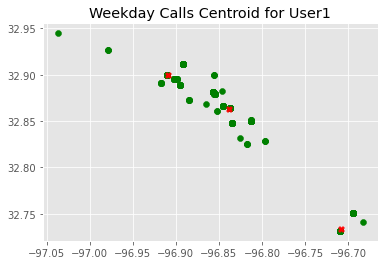

In [21]:
fig, ax = plt.subplots() 
ax.scatter(user1_weekday_daytime['TowerLon'], user1_weekday_daytime['TowerLat'], marker = 'o', c = 'green')

x = model_user1.cluster_centers_[0:,0].tolist()
y = model_user1.cluster_centers_[0:,1].tolist()
ax.scatter(x,y, marker = 'X', c = 'red')
ax.set_title('Weekday Calls Centroid for User1')

# Adanved part (15%  of the total score)

**17. Now that you have a system in place, repeat the the steps 12, 14 and 16 for all 10 individuals in the dataset.**

Cluster Info of User 1
Cluster Analysis Inertia:  0.15891069523780166
------------------------------------------

  Cluster  0
    Centroid  [-96.83818346  32.86348712]
    #Samples  140

  Cluster  1
    Centroid  [-96.70816184  32.73323174]
    #Samples  306

  Cluster  2
    Centroid  [-96.90951639  32.9000009 ]
    #Samples  959


Cluster Info of User 2
Cluster Analysis Inertia:  0.2657446177582843
------------------------------------------

  Cluster  0
    Centroid  [-96.9164561   32.73762409]
    #Samples  360

  Cluster  1
    Centroid  [-96.92355104  32.87096795]
    #Samples  921

  Cluster  2
    Centroid  [-96.93522725  32.69557708]
    #Samples  3121


Cluster Info of User 3
Cluster Analysis Inertia:  0.01955096987811486
------------------------------------------

  Cluster  0
    Centroid  [-96.88911725  32.81309497]
    #Samples  88

  Cluster  1
    Centroid  [-96.89338791  32.77992299]
    #Samples  846

  Cluster  2
    Centroid  [-96.86563953  32.86562866]
    #Sampl

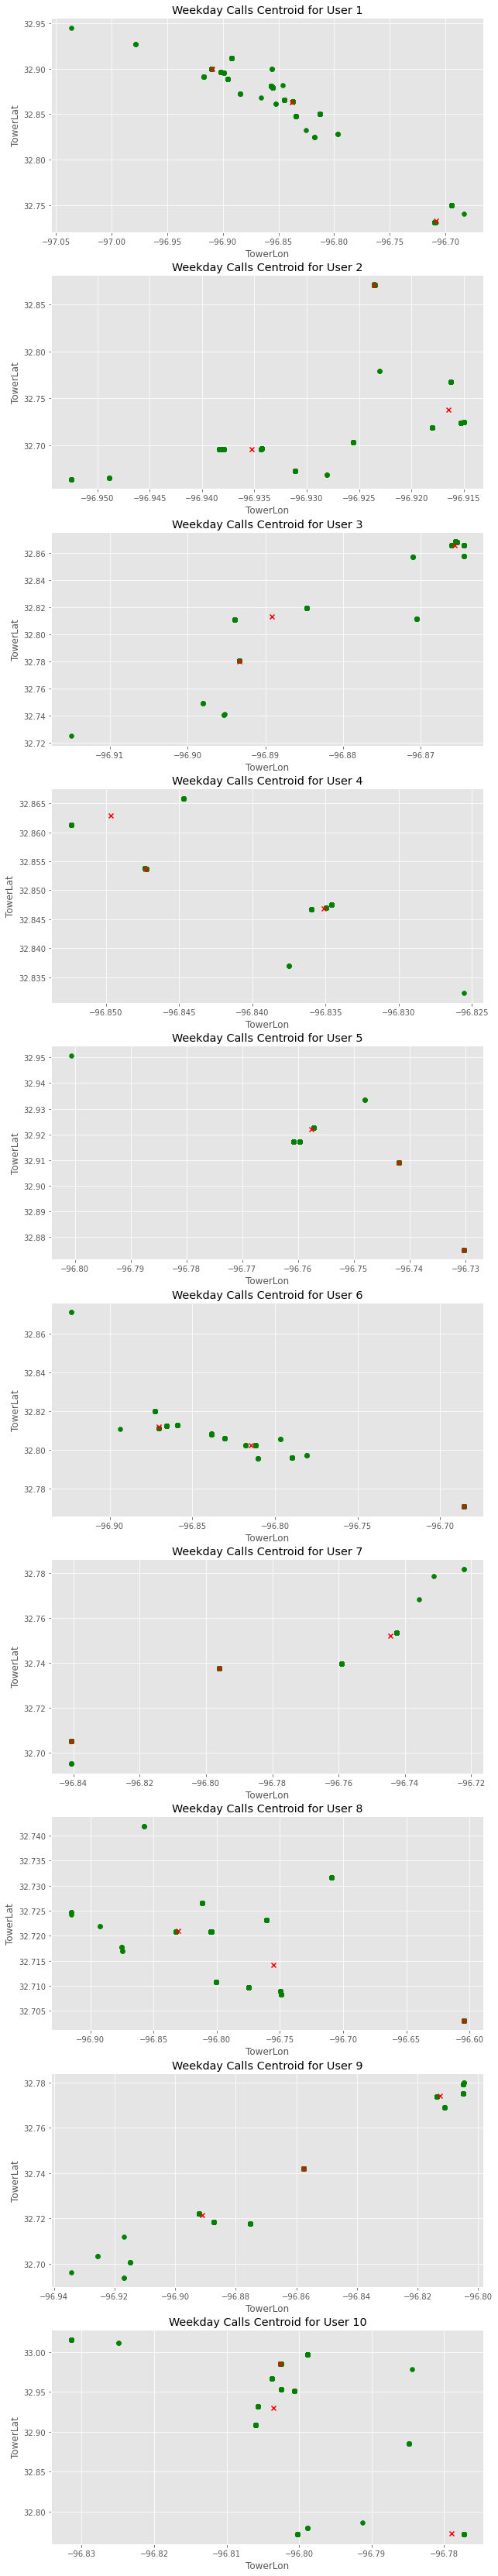

In [22]:
fig, ax = plt.subplots(len(list_In), figsize = (10,60))   
for i in range(0,len(list_In)):
    user = data[data['In'] == list_In[i]]
    user_weekday = user[(user['DOW'] != 'Sat') & (user['DOW'] != 'Sun')]
    user_weekday_daytime = user_weekday[user_weekday['CallTime'] < '17:00:00']
    
    ax[i].scatter(user_weekday_daytime['TowerLon'], user_weekday_daytime['TowerLat'], marker = 'o', c = 'green')
    ax[i].set_title('Call Locations for User ' + str(i+1) + ' working daytimes')
    ax[i].set_xlabel('TowerLon')
    ax[i].set_ylabel('TowerLat')
    
    model_user = doKMeans(user_weekday_daytime,3)
    
    print('Cluster Info of User ' + str(i+1))
    clusterInfo(model_user)
    print('\n')
    
    x = model_user.cluster_centers_[0:,0].tolist()
    y = model_user.cluster_centers_[0:,1].tolist()
    ax[i].scatter(x,y, marker = 'x', c = 'red')
    ax[i].set_title('Weekday Calls Centroid for User ' + str(i+1))